In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import anndata
import scipy.io as sio

In [2]:
import glob

In [ ]:
ms = glob.glob('./Xu-ln/*')

In [ ]:
for mf in ms:
    m = pd.read_csv(mf, sep='\t')
    bars =pd.DataFrame(m.columns)
    bars['Patient'] = mf.split('_')[1]
    bars['BC subtype'] = mf.split('_')[2]
    genes = m.reset_index()[['index']]
    mat = sparse.csr_matrix(m.to_numpy())
    samp = anndata.AnnData(X=mat.T, obs=bars, var=genes)
    samp.var.columns = ['gene']
    samp.obs.columns = ['barcode', 'Patient', 'BC subtype']
    samp.var_names = samp.var['gene']
    samp.obs_names = samp.obs['barcode']
    samp.var.columns = ['gene_hgnc']
    samp.obs.columns = ['bars', 'Patient', 'BC subtype']
    results_file = './processed/xu/'+ mf.split('_')[1] + '_'+ mf.split('_')[2] +'.h5ad'
    samp.write(results_file)

In [3]:
ms = glob.glob('./processed/xu/*')

In [4]:
def map_to_tissue(n):
    if n == '1':
        return 'Tumor'
    else:
        return 'Lymph node'

In [7]:
for i, m in enumerate(ms):
    data = sc.read_h5ad(m)
    data.obs['Tissue'] = map_to_tissue(m.split('_')[0].split('-')[1])
    data.obs.columns = ['bars', 'Sample', 'BC subtype', 'Tissue']
    data.obs['Patient'] = [s.split('-')[0] for s in data.obs['Sample']]
    if i == 0:
        adata = data
    else:
        adata = anndata.concat([adata, data])


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [8]:
adata.obs['barcode'] = [b + '-' + s  for b,s in zip(adata.obs['bars'], adata.obs['Sample'])]

adata.obs_names = adata.obs['barcode']

In [9]:
adata.obs = adata.obs[['bars', 'Sample', 'BC subtype', 'Tissue', 'Patient']]

In [10]:
results_file = './processed/xu_raw.h5ad'
adata.write(results_file)

... storing 'bars' as categorical
... storing 'Sample' as categorical
... storing 'BC subtype' as categorical
... storing 'Tissue' as categorical
... storing 'Patient' as categorical


In [6]:
xu = sc.read_h5ad('./processed/xu_raw.h5ad')

In [16]:
xu.obs['barcode'] = [b + '-' + s  for b,s in zip(xu.obs['bars'], xu.obs['Sample'])]

In [17]:
xu.obs_names = xu.obs['barcode']

In [7]:
xu.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 117481 × 17872
    obs: 'bars', 'Sample', 'BC subtype', 'Tissue', 'Patient'>

In [19]:
xu

AnnData object with n_obs × n_vars = 117481 × 17872
    obs: 'bars', 'Sample', 'BC subtype', 'Tissue', 'Patient', 'barcode'

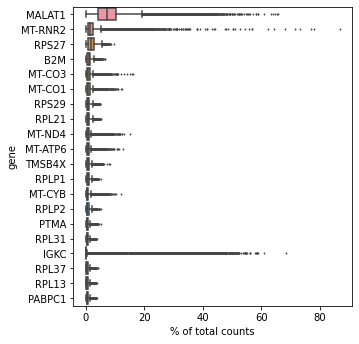

In [8]:
sc.pl.highest_expr_genes(xu, n_top=20)

In [9]:
sc.pp.filter_genes(xu, min_cells=3)
xu.var['mt'] = xu.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(xu, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

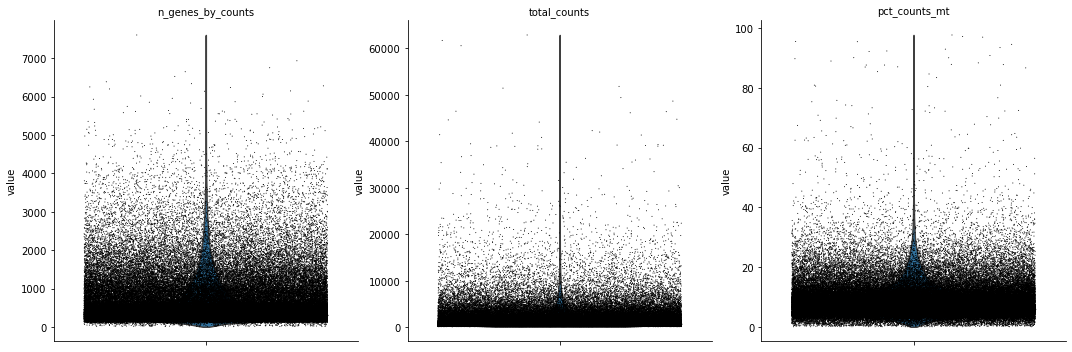

In [10]:
sc.pl.violin(xu, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

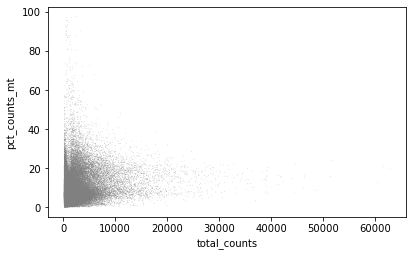

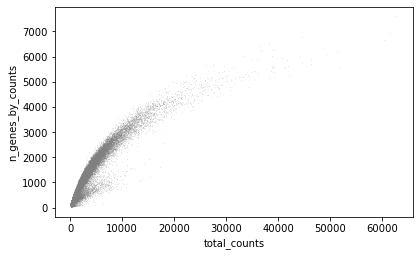

In [11]:
sc.pl.scatter(xu, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(xu, x='total_counts', y='n_genes_by_counts')

In [12]:
xu = xu[xu.obs.n_genes_by_counts < 2500, :]
xu = xu[xu.obs.pct_counts_mt < 20, :]

In [14]:
sc.pp.normalize_total(xu, target_sum=1e4)

/home/olam/miniconda3/envs/integration/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(xu)

In [28]:
xu.obs= xu.obs[['bars', 'Sample', 'BC subtype', 'Tissue', 'Patient',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt']]

In [16]:
results_file = './processed/xu_filtered.h5ad'
xu.write(results_file)

In [5]:
xu = sc.read_h5ad("./processed/xu_filtered.h5ad")

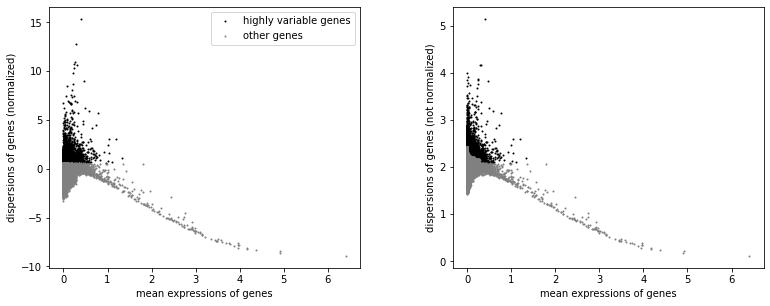

In [7]:
sc.pp.highly_variable_genes(xu, n_top_genes=5000, flavor='cell_ranger')
sc.pl.highly_variable_genes(xu)

In [8]:
xu = xu[:, xu.var.highly_variable]

In [9]:
sc.pp.regress_out(xu, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(xu, max_value=10)

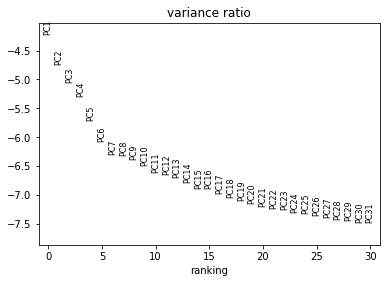

In [10]:
sc.tl.pca(xu)
sc.pl.pca_variance_ratio(xu, log=True)

In [11]:
xu

AnnData object with n_obs × n_vars = 108780 × 5000
    obs: 'bars', 'Sample', 'BC subtype', 'Tissue', 'Patient', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [12]:
sc.pp.neighbors(xu, n_pcs=20)

/home/olam/miniconda3/envs/single/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


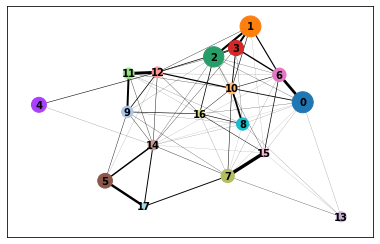

In [13]:
sc.tl.leiden(xu, resolution=0.5)
sc.tl.paga(xu)
sc.pl.paga(xu)
sc.tl.umap(xu, init_pos='paga')

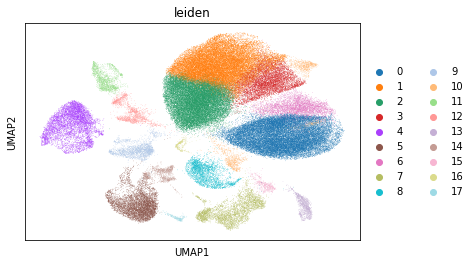

In [15]:
sc.pl.umap(xu, color='leiden')

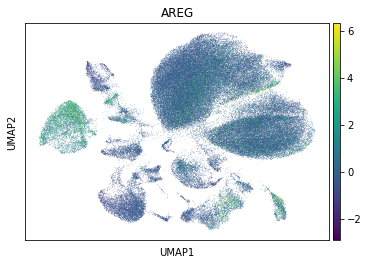

In [19]:
sc.pl.umap(xu, color='AREG')

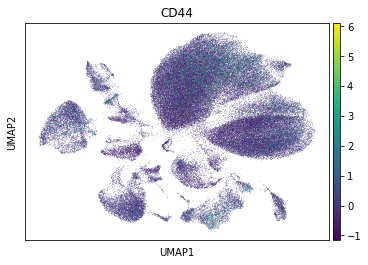

In [22]:
sc.pl.umap(xu, color='CD44')